In [2]:
# Script to visualize the attention activations and block activations of the LLaMA model.
import matplotlib.pyplot as plt
import numpy as np
import pickle # import the pickle module
from pickle import UnpicklingError # import the UnpicklingError module
from scipy.ndimage import gaussian_filter1d

In [3]:
# read the log file and load the attention matrix using pickle
log_file = open('attention_log.pkl', 'rb') # open the file in read binary mode
data = []
try:
    while True:
        p = pickle.load(log_file) # load the data as a dictionary
        data.append(p)
except EOFError: # break when there is no more data to read
    pass
except UnpicklingError:
    pass
log_file.close() # close the file

In [5]:
len(data)

32

In [6]:
data[0]['att_matrix'].shape

torch.Size([1, 32, 4096, 4096])

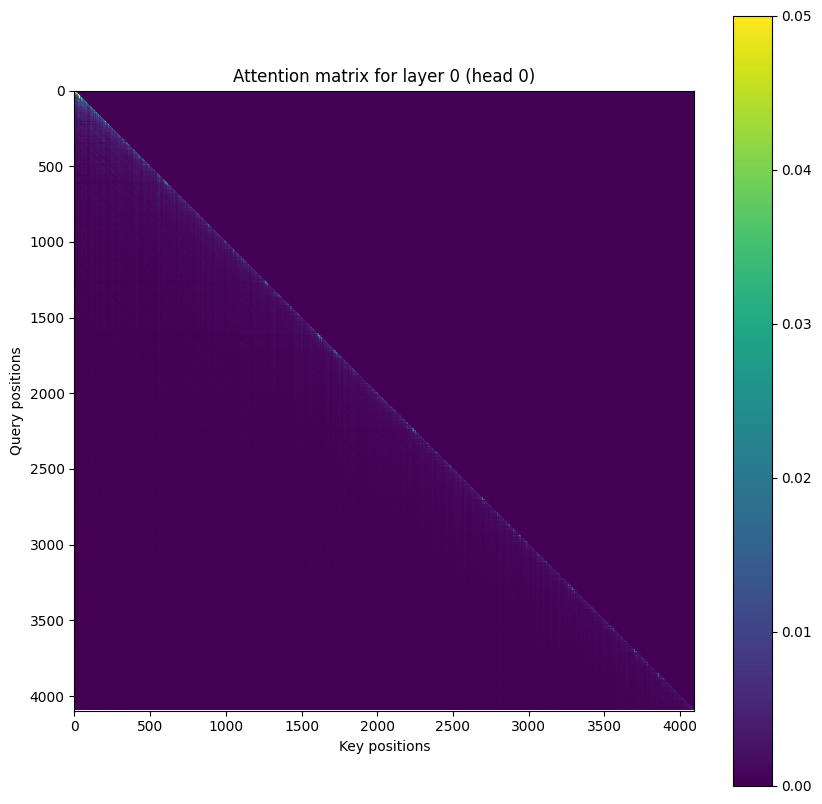

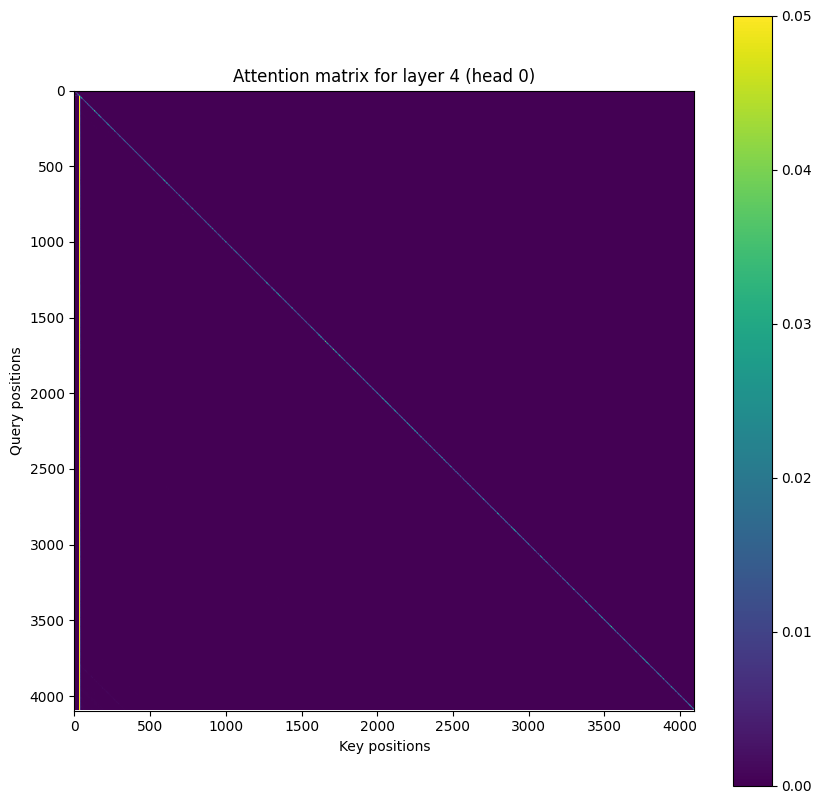

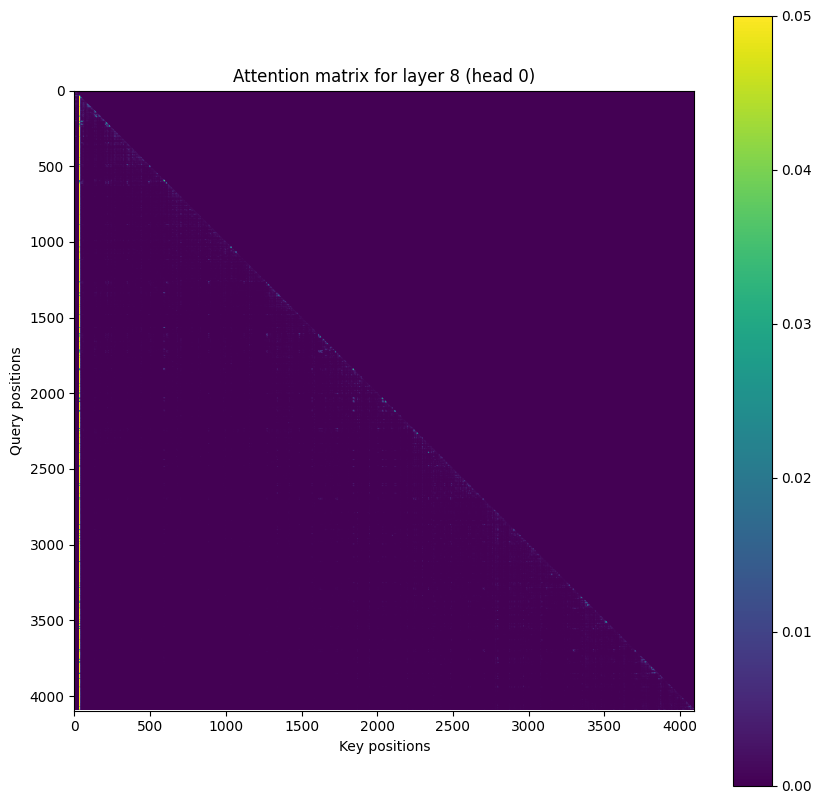

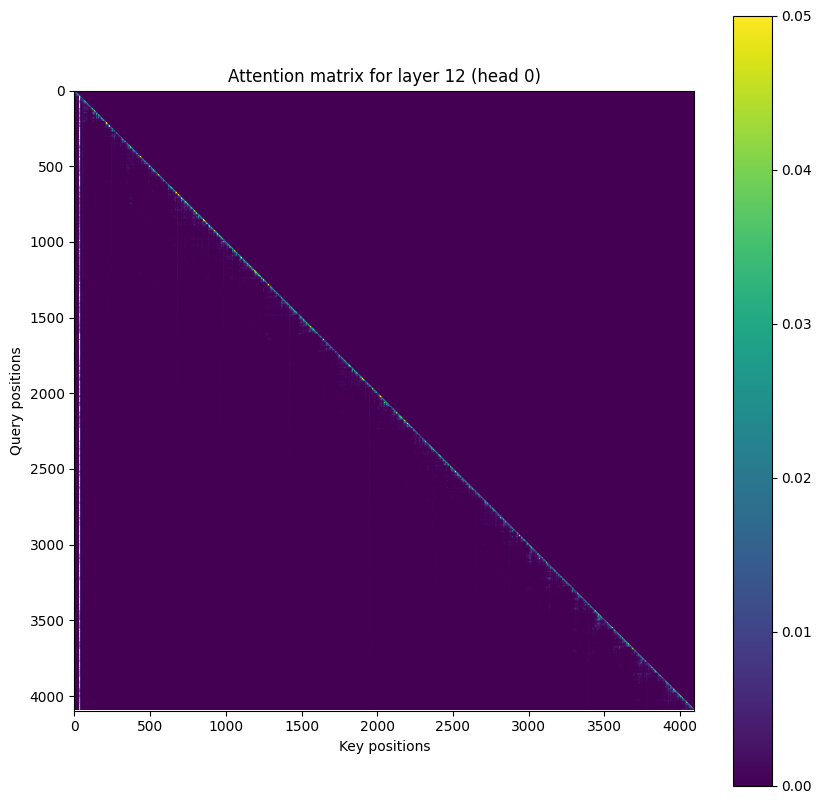

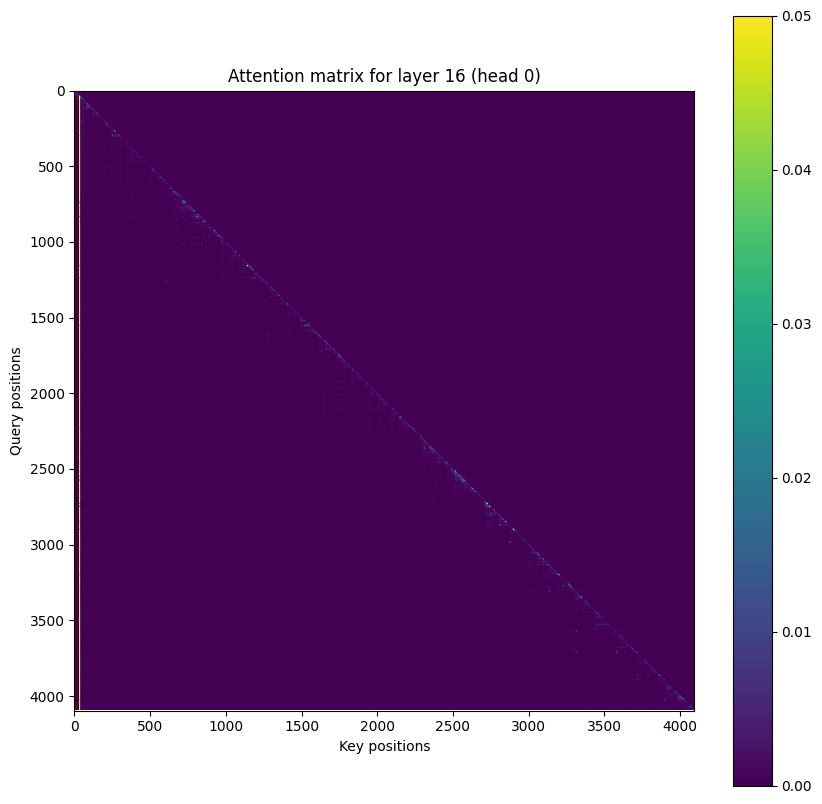

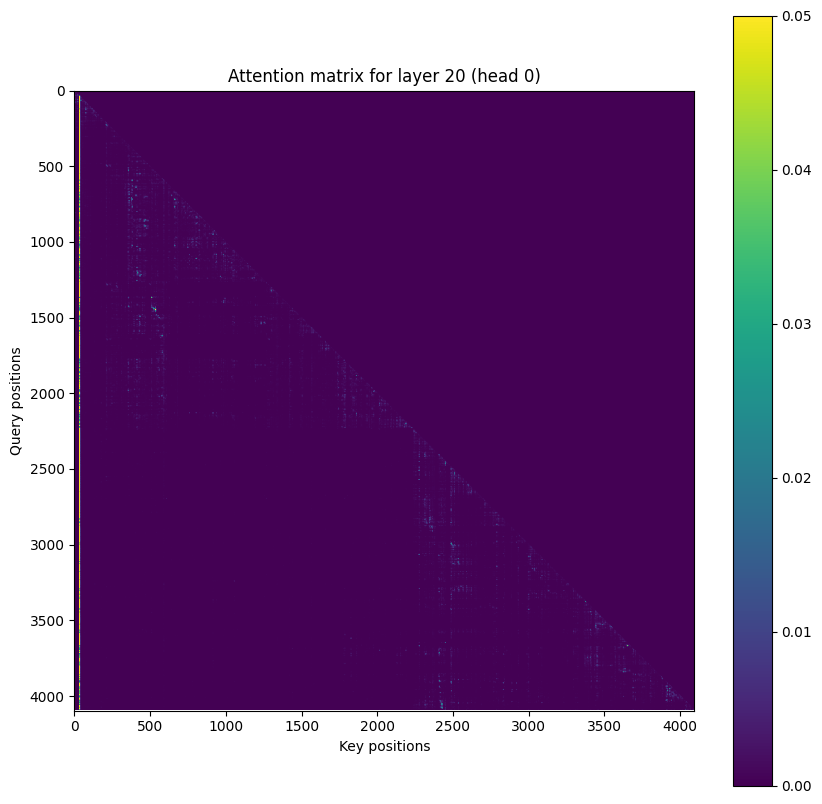

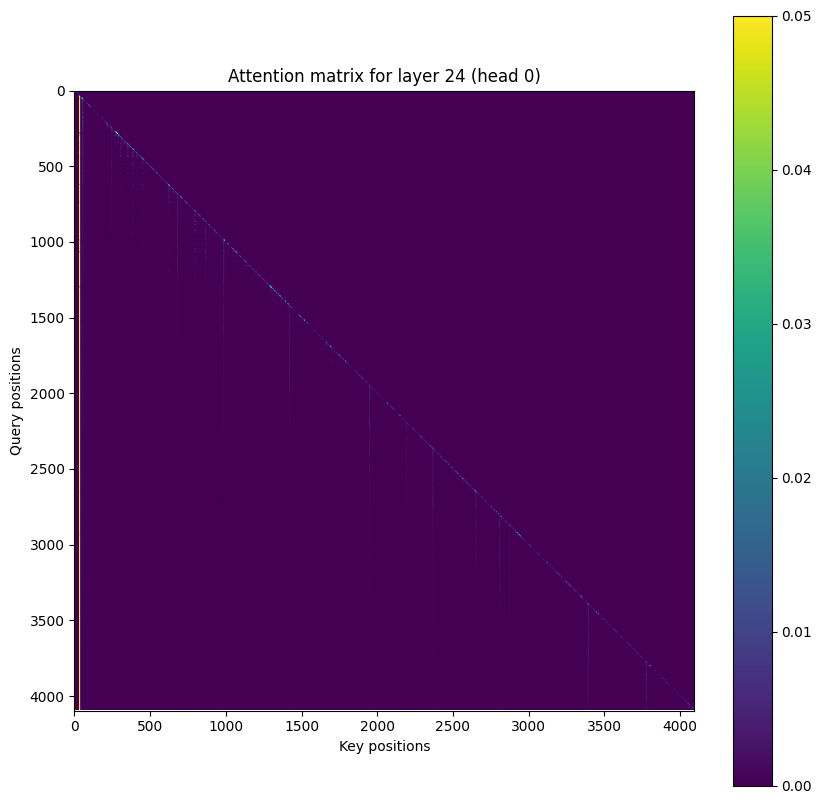

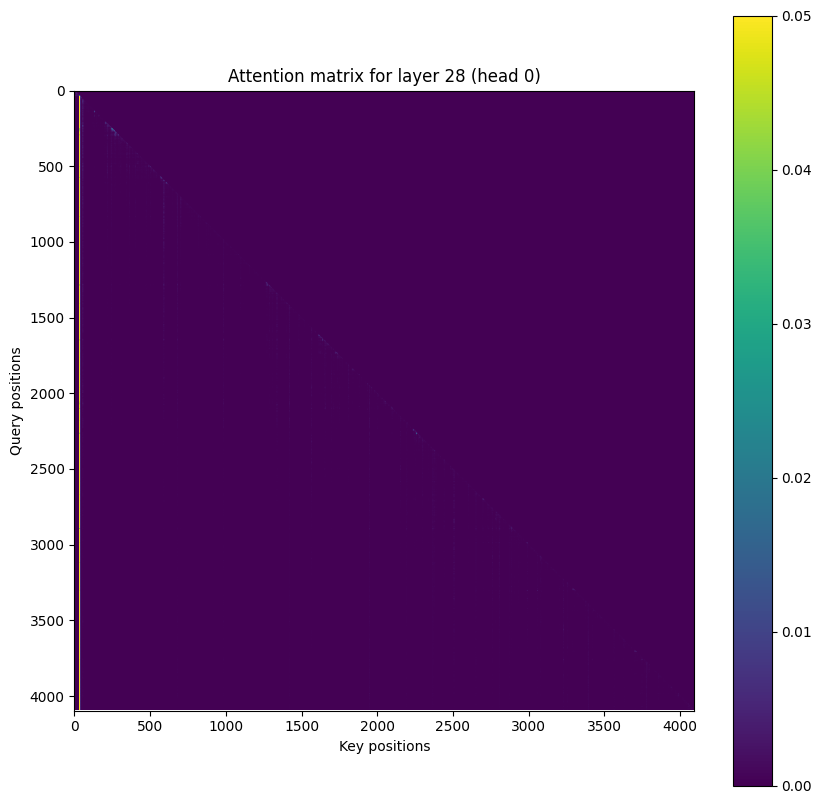

In [15]:
# plot the attention matrix for each batch and each head
# sample random batches
random_batches = np.random.randint(0, len(data), size=1)
# print every 4 layers
n_layers = 32
layers = range(0, n_layers, 4)
for i in layers:
    plt.figure(figsize=(10, 10))
    plt.title(f'Attention matrix for layer {i} (head 0)')
    mat = data[i]['att_matrix'][0, 0].cpu() # remove the batch dimension
    plt.imshow(mat, cmap='viridis', vmin=0, vmax=0.05)
    plt.colorbar()
    plt.xlabel('Key positions')
    plt.ylabel('Query positions')
    # plt.savefig(f'logs/images/attention_batch_{i+1}.png')
    plt.show()

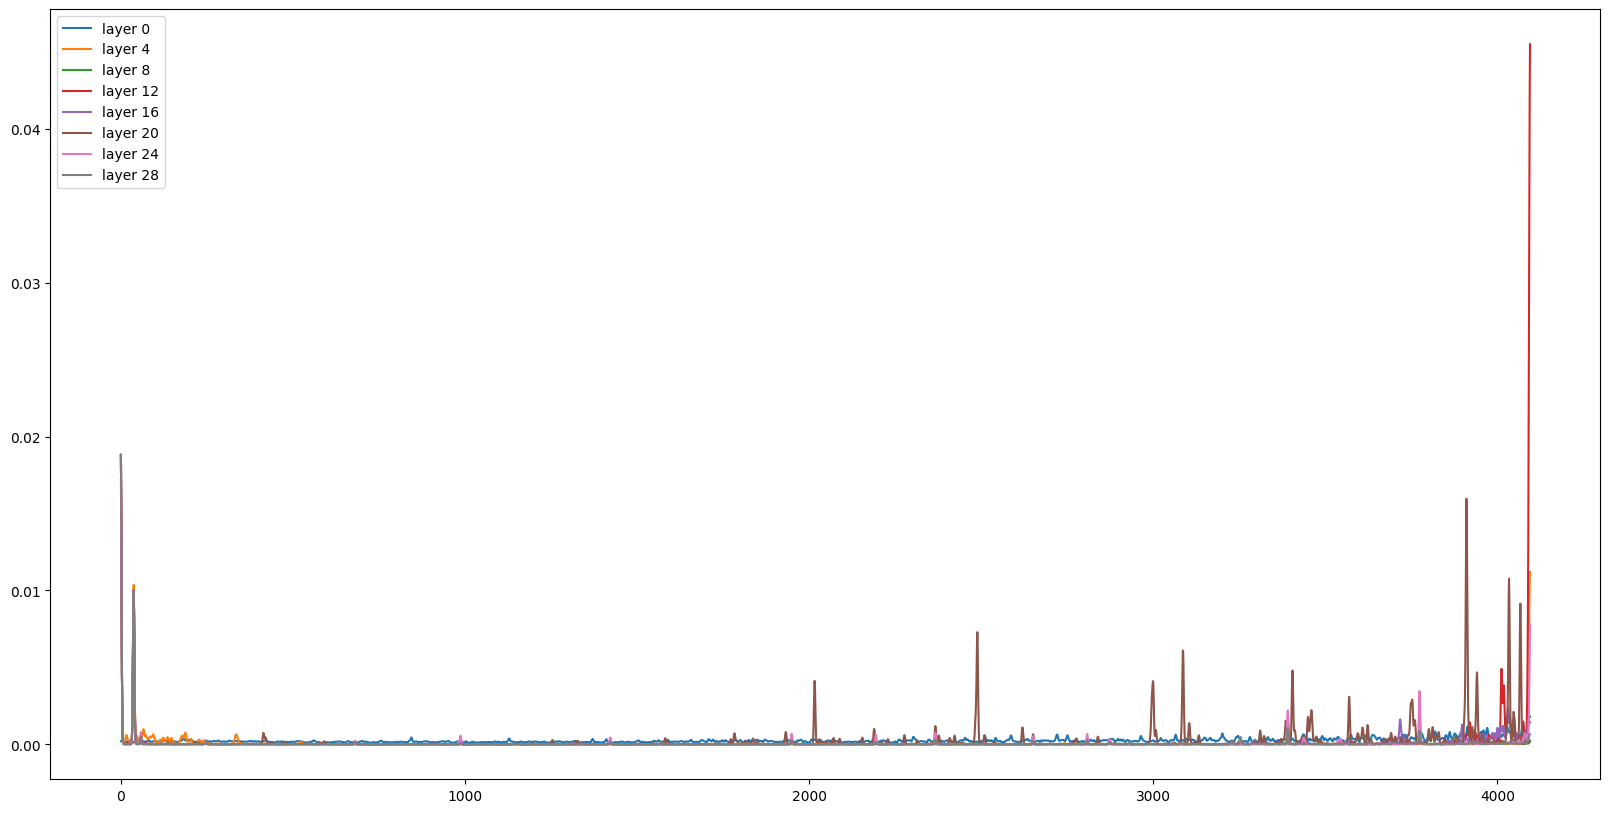

In [20]:
# we want to visualize the distribution of attention at every layer, but only at the last token position
# graph all the distributions in one plot
plt.figure(figsize=(20, 10))
for i in layers:
    mat = data[i]['att_matrix'][0, 0, -1, :].cpu().numpy()
    # need to scale down the more extreme values to see the rest of the data
    mat = np.clip(mat, 0, 0.05)
    # convert from float16 to format compatible with gaussian_filter1d
    mat = mat.astype(np.float64)
    # smoothen the distribution so it looks like one curve using a gaussian filter
    mat = gaussian_filter1d(mat, sigma=2)

    plt.plot(mat, label='layer {}'.format(i))
plt.legend()

In [5]:
log_file = open('logs/llama_log.pkl', 'rb') # open the file in read binary mode
data = []
try:
    while True:
        p = pickle.load(log_file) # load the data as a dictionary
        data.append(p)
except EOFError: # break when there is no more data to read
    pass
except UnpicklingError:
    pass
log_file.close() # close the file

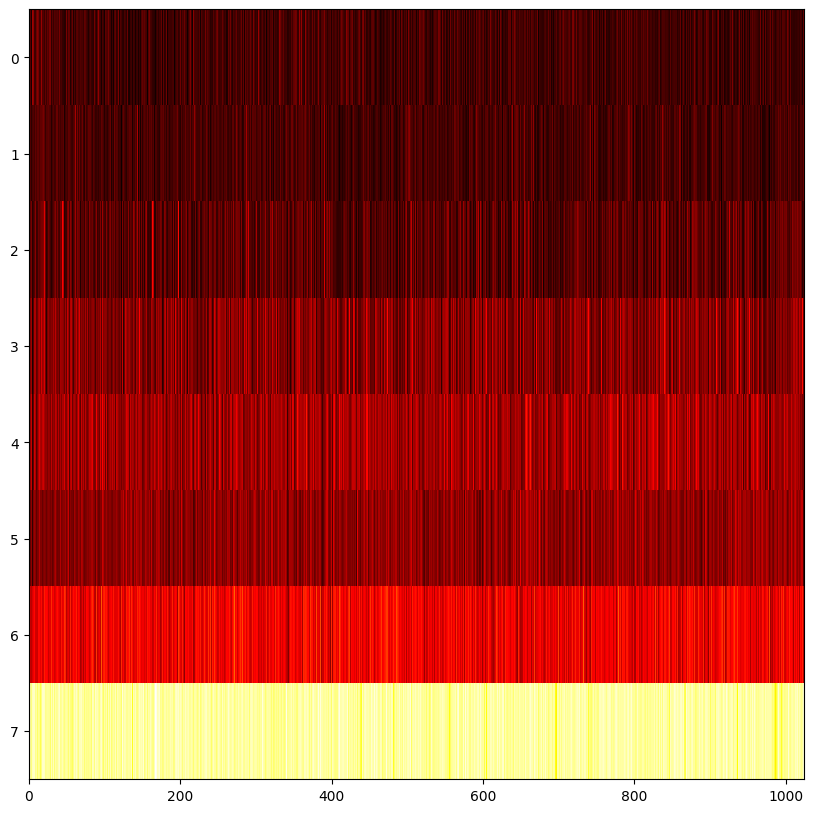

In [37]:
# visualize changes between vectors in the block activations
# data contains {layer: int, block_activations: np.array}
# basically for each token position 0-1024, we want to track the difference in change between the activations of each block
# do this by calculating the euclidean distance between the activations of each block at each position
n_layers = 8
diffs = np.zeros((n_layers, 1024))
for i in range(n_layers):
    # first normalize the activations
    now = data[i]['block_activations'][0, :, :]
    now = now / np.sqrt(np.sum(now**2, axis=1, keepdims=True))
    then = data[i+1]['block_activations'][0, :, :]
    then = then / np.sqrt(np.sum(then**2, axis=1, keepdims=True))
    diffs[i] = np.linalg.norm(now - then, axis=1)
# plot the differences
plt.figure(figsize=(10, 10))
plt.imshow(diffs, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()